<a href="https://colab.research.google.com/github/rozerinyildiz/ImageProcesssing-GAN-Augmentation-/blob/main/GAN_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet34
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import random

manualSeed = 999


random.seed(manualSeed)
torch.manual_seed(manualSeed)


from collections import Counter


import os



import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set_style('whitegrid')


import numpy as np


from time import time


import altair as alt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
transform ={
        'train': transforms.Compose(
                [transforms.Resize((150,150)),
                 transforms.ToTensor(),
                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ]),
         'test':transforms.Compose([transforms.Resize((150,150)),                     
               transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])}


data_train=ImageFolder('/content/drive/MyDrive/splitted_final_skin_diseases(original)/training/', transform=transform['train'])
data_test=ImageFolder('/content/drive/MyDrive/splitted_final_skin_diseases(original)/testing/', transform=transform['test'])



train_loader=DataLoader(data_train, batch_size=128,shuffle=True)

test_loader=DataLoader(data_test,batch_size=32)



classes=np.sort(os.listdir('/content/drive/MyDrive/splitted_final_skin_diseases(original)/training/'))

In [ ]:
print(data_train.class_to_idx)

{'eczema': 0, 'keratosis_pilaris': 1, 'melanoma': 2, 'rosacea': 3}


In [ ]:
cl=dict(Counter(data_train.targets))

print(f"training dataset size: {len(data_train.targets)}")

training dataset size: 261


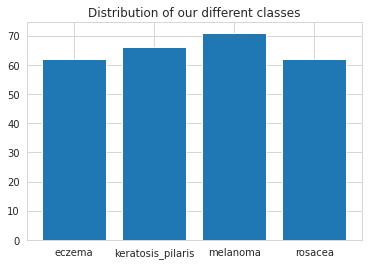

In [ ]:
plt.bar(classes, cl.values());

plt.title('Distribution of our different classes');

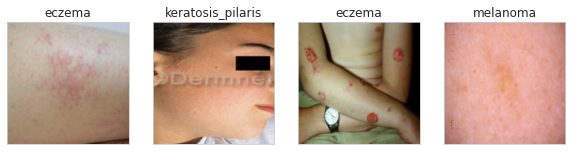

In [ ]:
img,label=next(iter(train_loader))


mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],   #To see images better with matplotlib
   std= [1/s for s in std])                    



def imshow(img):
    img=unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    imshow(img[i])
    plt.title(classes[label[i]])
    plt.xticks([]), plt.yticks([])
    

In [ ]:
class Classifieur(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),  
        nn.ReLU(), 
        nn.MaxPool2d(2,2), 
        nn.Dropout2d(0.5),    
        
        
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),   
        nn.ReLU(),  
        nn.MaxPool2d(2,2),  
        nn.Dropout2d(0.5),  
            
        
        nn.Flatten(),
        nn.Linear(in_features=16*34*34, out_features=120),
        nn.ReLU(),
        nn.Dropout(0.5),    
        
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Dropout(0.5) ,   
            
        nn.Linear(84,6),
           
        )
        
        
    def forward(self, x):
        return self.network(x)
    

In [ ]:
def train(model,optimizer,train_loader, test_loader, path):
    
    '''
    inputs:
    ----------------------------------------
     model: the model to train
     train_loader: the training set
     test_loader: the test set
     lr:learning rate
    
    
    return:
    -----------------------------------------
    
     model: best model based on accruracy value on test
     accuracy_stats: evolution of accuracy on learning and test data
     loss_stats: the evolution of the loss on learning and testing
    
    
    '''

    accuracy_stats = {
        'train': [],
        "test": []
    }


    loss_stats = {
        'train': [],
        "test": []
    }




    best_accuracy=0
    epochs=100


    criterion=nn.CrossEntropyLoss()

    start=time()
    for epoch in range(epochs):

        train_epoch_loss=0
        train_epoch_accuracy=0
        total=0

        total_test=0


        for i,(inp,label) in enumerate(train_loader):
            output=model(inp)
            loss=criterion(output,label)

            optimizer.zero_grad() # reset the gradients
            loss.backward() #Calculate the gradient
            optimizer.step() #update weights and biases


            train_epoch_loss+=loss.item()  #For each epoch, I calculate the total loss
            total+=label.size(0)
            _, predicted = torch.max(output.data, 1) #I predict the class
            train_epoch_accuracy+=(predicted == label).sum().item()

        train_epoch_loss/=total #I take the average
        train_epoch_accuracy/=total
        loss_stats['train'].append(train_epoch_loss)
        accuracy_stats['train'].append(train_epoch_accuracy)   


        with torch.no_grad(): #No need to accumulate the gradient during this phase

            model.eval()     #evaluation mode (some layers are disabled)

            test_epoch_loss=0
            test_epoch_accuracy=0


            for i,(inp,label) in enumerate(test_loader):

                output_test=model(inp)
                test_loss=criterion(output_test,label)

                test_epoch_loss+=test_loss.item()
                total_test+=label.size(0)
                _, predicted = torch.max(output_test.data, 1)
                test_epoch_accuracy+=(predicted == label).sum().item()

            test_epoch_loss/=total_test  
            test_epoch_accuracy/=total_test 
            loss_stats['test'].append(test_epoch_loss)
            accuracy_stats['test'].append(test_epoch_accuracy)


            if test_epoch_accuracy>best_accuracy:
                best_accuracy=test_epoch_accuracy
                torch.save(model.state_dict(), path) #save the best model according to accuracy





            #if epoch % 5 == 0:
            print(f'epoch[{epoch+1}/{epochs}]\t train loss:{train_epoch_loss:.3f}\t test loss: {test_epoch_loss:.3f}')
    end=time()



    print(f'(time: {end-start}')
    
    
    model.load_state_dict(torch.load(path))
    
    
    return model, accuracy_stats, loss_stats
    

In [ ]:
lr=0.001
model=Classifieur()
optimizer=torch.optim.Adam(model.parameters(),lr=lr, weight_decay=0.005)


best_model_Classifieur, accuracy_stats_Classifieur, loss_stats_Classifieur=\
            train(model=model,optimizer=optimizer,train_loader=train_loader, test_loader=test_loader,path='./classifieur.pth')

epoch[1/100]	 train loss:0.020	 test loss: 0.057
epoch[2/100]	 train loss:0.017	 test loss: 0.049
epoch[3/100]	 train loss:0.015	 test loss: 0.044
epoch[4/100]	 train loss:0.014	 test loss: 0.055
epoch[5/100]	 train loss:0.013	 test loss: 0.045
epoch[6/100]	 train loss:0.012	 test loss: 0.039
epoch[7/100]	 train loss:0.010	 test loss: 0.042
epoch[8/100]	 train loss:0.010	 test loss: 0.040
epoch[9/100]	 train loss:0.011	 test loss: 0.040
epoch[10/100]	 train loss:0.009	 test loss: 0.037
epoch[11/100]	 train loss:0.008	 test loss: 0.046
epoch[12/100]	 train loss:0.008	 test loss: 0.048
epoch[13/100]	 train loss:0.008	 test loss: 0.035
epoch[14/100]	 train loss:0.007	 test loss: 0.032
epoch[15/100]	 train loss:0.007	 test loss: 0.047
epoch[16/100]	 train loss:0.007	 test loss: 0.041
epoch[17/100]	 train loss:0.008	 test loss: 0.030
epoch[18/100]	 train loss:0.006	 test loss: 0.044
epoch[19/100]	 train loss:0.007	 test loss: 0.042
epoch[20/100]	 train loss:0.008	 test loss: 0.033
epoch[21/

In [ ]:
#The saved model corresponds to the model with the highest accuracy value
i=np.argmax(accuracy_stats_Classifieur['test'])


print(f"accuracy train: {accuracy_stats_Classifieur['train'][i]:.2f}")
print(f"accuracy test: {accuracy_stats_Classifieur['test'][i]:.2f}")

accuracy train: 0.97
accuracy test: 0.88


In [ ]:
# I create the dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_Classifieur).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_Classifieur).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

#I trace loss and accuracy for train and test


char1=alt.Chart(train_val_acc_df).mark_line().encode(
            x=alt.X('epochs:O',scale=alt.Scale(zero=False)),
            y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
            color='variable:N').properties(height=300,width=300,title='Accuracy')


char2=alt.Chart(train_val_loss_df).mark_line().encode(
            x='epochs:O',
            y='value:Q',
            color='variable:N').properties(height=300,width=300,title='Loss')

alt.hconcat(char1,char2).resolve_scale(y='independent')

alt.HConcatChart(...)

#Features selection avec Resnet34

In [ ]:
model = resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad=False   #We don't need the gradient for these layers


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  #Gradient defaults to True

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
optimizer=torch.optim.Adam(model.fc.parameters()) #Only the parameters of the last layer are updated



best_model, accuracy_stats_resnet, loss_stats_resnet=\
        train(model=model, optimizer=optimizer,train_loader=train_loader, test_loader=test_loader,path='./classifieur2.pth')

epoch[1/100]	 train loss:0.019	 test loss: 0.052
epoch[2/100]	 train loss:0.017	 test loss: 0.045
epoch[3/100]	 train loss:0.013	 test loss: 0.038
epoch[4/100]	 train loss:0.012	 test loss: 0.033
epoch[5/100]	 train loss:0.011	 test loss: 0.031
epoch[6/100]	 train loss:0.008	 test loss: 0.029
epoch[7/100]	 train loss:0.008	 test loss: 0.029
epoch[8/100]	 train loss:0.008	 test loss: 0.028
epoch[9/100]	 train loss:0.007	 test loss: 0.025
epoch[10/100]	 train loss:0.006	 test loss: 0.023
epoch[11/100]	 train loss:0.007	 test loss: 0.021
epoch[12/100]	 train loss:0.007	 test loss: 0.019
epoch[13/100]	 train loss:0.006	 test loss: 0.018
epoch[14/100]	 train loss:0.006	 test loss: 0.018
epoch[15/100]	 train loss:0.005	 test loss: 0.018
epoch[16/100]	 train loss:0.004	 test loss: 0.018
epoch[17/100]	 train loss:0.005	 test loss: 0.017
epoch[18/100]	 train loss:0.005	 test loss: 0.016
epoch[19/100]	 train loss:0.004	 test loss: 0.015
epoch[20/100]	 train loss:0.004	 test loss: 0.015
epoch[21/

In [ ]:
i=np.argmax(accuracy_stats_resnet['test'])


print(f"accuracy train best model resnet: {accuracy_stats_resnet['train'][i]:.2f}")
print(f"accuracy test best model resnet: {accuracy_stats_resnet['test'][i]:.2f}")

accuracy train best model resnet: 0.98
accuracy test best model resnet: 0.97


In [ ]:
# I create the dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_resnet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_resnet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

#I trace loss and accuracy for train and test


char1=alt.Chart(train_val_acc_df).mark_line().encode(
            x=alt.X('epochs:O',scale=alt.Scale(zero=False)),
            y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
            color='variable:N').properties(height=300,width=300,title='Accuracy')


char2=alt.Chart(train_val_loss_df).mark_line().encode(
            x='epochs:O',
            y='value:Q',
            color='variable:N').properties(height=300,width=300,title='Loss')

alt.hconcat(char1,char2).resolve_scale(y='independent')

alt.HConcatChart(...)

In [ ]:
def get_prediction(model,data_loader):
    
    prediction=[]
    lab=[]
    with torch.no_grad():
        model.eval()
        for data in data_loader:
            inp, labels = data
            outputs = model(inp)
            _, predicted = torch.max(outputs.data, 1)

            prediction.extend(predicted.squeeze().tolist())
            lab.extend(labels.squeeze().tolist())
    return prediction,lab

In [ ]:
prediction,label=get_prediction(best_model,test_loader)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix


print(classification_report(label,prediction,zero_division=0,target_names=classes))

                   precision    recall  f1-score   support

           eczema       0.93      1.00      0.96        27
keratosis_pilaris       0.96      0.92      0.94        26
         melanoma       1.00      1.00      1.00        30
          rosacea       1.00      0.97      0.98        30

         accuracy                           0.97       113
        macro avg       0.97      0.97      0.97       113
     weighted avg       0.97      0.97      0.97       113



In [ ]:
idx2Class={v:classes[v] for v in range(4)}


df_confusion=pd.DataFrame(confusion_matrix(label,prediction)).rename(columns=idx2Class,index=idx2Class)


conf=df_confusion.reset_index().melt('index')
conf.columns=['True value','prediction','number']
b=alt.Chart(conf).encode(
            x='prediction:N',
            y='True value:N'
    ).properties(height=400,width=400)

rec=b.mark_rect().encode(
            color='number'
        )
text=b.mark_text().encode(
        text=alt.Text('number')
)

rec+text

alt.LayerChart(...)